General workflow:
------
* 1. convert PDF to gray scale images
    *  [x] 1.1 for local version just make sure the pdf is in an empty folder
    *  [ ] 1.2 needs some design for online service version; 
        * 1.2.1 make sure that only one user at a time by throw back 'server in use' (can check on multiuser app later)
        * 1.2.2 save the user-uploaded pdf; convert and save images to a destinated folder; clear folder after task
        * 1.2.3 need a timer to monitor and shut down inactive user; clear folder if confirmed inactive 
* 2. establish template
    *  [x] 2.1 build template for alignment and response reading
    *  [x] 2.2 by using pre-made form, just pick the first image as template, pick 4 corner circles and establish ALIGNMENT_PARAM **probably can square it by ave(x), ave(y)**
    *  [x] 2.3 align self, assert alignment fail other than move on if issue occurs
    *  [ ] 2.4 set ROIs for id, answers. currently hard coded, need gui for manual pick and/or ML for autodetect
    *  [ ] 2.5 find the ID box (centroid, w, h) as orientation check point. ML for autodetect
* 3. process images and combine results
    for each image,
    *  [ ] 3.1 *align image*; use the ID box to check orientation, rotate 180 if necessary; *try to pick out the 4 corner circles by fine-tuning params;* 
        * [ ] i. if fail, REPORT error 'cannot align image' and image with last attempt; move on to next image
        * [x] ii. if good, 'alignment succeeded'
    * 3.2 extract responses; mask out non-responses; try to pick out all circles (#Q*5) by tuning params; 
        * [ ] i. if fail, REPORT error 'cannot find all answers' and image with last attempt; move on to next image
        * [ ] ii. if good, 'answer extraction succeeded'
    * 3.3 extract IDs; mask out non-IDs; try to pick out all digits (#ID*10) by tuning params; 
        * [ ] i. if fail, REPORT error 'cannot find all IDs' and image with last attempt; assign fake ID
        * [x] ii. if good, 'ID extraction succeeded'; append (imagexx, ans, id) to RESULT
* 4. generate output files
    * [ ] 3.1 if there are errors, report all errors (error ID, image name, error name), label and save error images in destinated folder; early termination if more than 10 errors detected. 
    * [ ] 3.2 save output as a .csv file for BubbleProcess


### some thoughts for future improvement:
0. directory check and reuse
1. rotate up-side-down pictures before alignment
2. save grading results on image and combine to pdf
3. autoadjust region of interest(ROI)
4. exam analysis

### developer journal
* 2019.9.21  framework established. quite a few misses and false results. need to save result image along the way.

3 images processed in 37066.910 ms.
    with 3 success and 0 errors.
['Image001;B;E;C;A;D;D;D;D;E;C;C;B;C;C;D;C;D;C;E;B;A;B;C;C;D;B;A;D;A;C;D;A;C;B;A;A;;B;;;A', 'Image002;B;E;E;D;D;E;D;E;E;B;C;B;A;C;D;A;E;D;C;C;B;B;A;C;A;B;;B;C;;;B;;;;A;;;D;B;', 'Image003;D;E;E;A;D;D;C;D;E;B;C;B;B;C;D;B;E;A;B;B;D;A;B;C;D;A;A;C;A;A;D;B;A;D;D;A;;D;;E;'] []
* 2019.9.22  adjust processing logic. add read ids. now 3 misses in 13 * (35 + 3) readings. saving outputs along the way is not slowing the program down.
    * before adjusting threshhold to fix the misses. implement catcher for exams that have either 0 or more than 1 answers for any question. if 0 answer, circle all options the program checked; if more than 1, circle all answers
    
13 images processed in 159644.334 ms.
    with 13 success and 0 errors.
 ['Image001;B;E;C;A;D;D;D;D;E;C;C;B;C;C;D;C;D;C;E;B;A;B;C;C;D;B;A;D;A;C;D;A;C;B;A;0;1;5', 'Image002;B;E;E;D;D;E;D;E;E;B;C;B;A;C;D;A;E;D;C;C;B;B;A;C;A;B;;B;C;;;B;;;;0;8;1', 'Image003;D;E;E;A;D;D;C;D;E;B;C;B;B;C;D;B;E;A;B;B;D;A;B;C;D;A;A;C;A;A;D;B;A;D;D;0;3;4', ...
 
 catcher implemented: 
 13 images processed in 161.699 s (12.44 s/image).
    with 13 success and 0 errors.
 
 * 2019.9.23 almost done with process_imgs. make find_corners harsher to force misalignment and errors. the catcher seems working. the Hough circle method is not very robust, probably need countours + area filter -> weight centroid instead.
     * new find_corners implemented. alignment looks neat and sharp now.

13 images processed in 160.509 s (12.35 s/image).
    with 13 success and 0 errors.

In [106]:
# Standard imports
import tempfile
import os
import time
from pdf2image import convert_from_path, convert_from_bytes
from pdf2image.exceptions import (
    PDFInfoNotInstalledError,
    PDFPageCountError,
    PDFSyntaxError
)
%matplotlib inline
from scipy.signal import convolve2d
import argparse
import cv2
from matplotlib import pyplot as plt
from matplotlib import gridspec
import pandas as pd
import numpy as np;

In [144]:
# parameters
PDFINPUT = 'test.pdf'

# PATH = os.path.dirname(os.path.realpath('__file__'))
SRC_IMG = 'srcimg'
OUT_IMG = 'outimg'
# TEMPLATE = "{}\Image001.jpg".format(os.path.join(PATH, SRC_IMG))

IDS = [[3,'0123456789',1]]        
ANSWERS = [[35,'ABCDE',0]]    

In [ ]:
main(PDFINPUT, SRC_IMG,OUT_IMG, IDS, ANSWERS)

In [22]:
def main(PDFINPUT, SRC_IMG, OUT_IMG, IDS, ANSWERS):
    PATH = os.path.dirname(os.path.realpath('__file__'))
    srcimg = os.path.join(PATH, SRC_IMG)
    outimg = os.path.join(PATH, OUT_IMG)
    print("source images @ {}".format(srcimg))
    print("Output images @ {}".format(srcimg))
    image_scanned = 13 # convert_pdf(PDFINPUT, srcimg)
    
    firstImg = cv2.imread('{}\Image001.jpg'.format(srcimg), 0)
    alignment = build_alignment(firstImg)
    
    ids, ans = build_template(firstImg, alignment, IDS, ANSWERS)

    res, err = process_imgs(srcimg, alignment, ids, IDS, ans, ANSWERS, outimg, image_scanned)

    generate_report(res, err, outimg)

In [246]:
# process img
def align_img(img, alignment):
    print('align_img')
    points1 = get_corners(img)
    points2 = alignment
    
    if (points1 is None or len(points1) != 4):
        img_circled = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        if points1 is not None:
            for i in range(len(points1)):
                c = points1[i]
                cv2.circle(img_circled, (c[0], c[1]), 60, (0, 255, 0), 4)
        else:
            cv2.putText(img_circled, "Cannot find any corner!!!",
                       (200,200), cv2.FONT_HERSHEY_SIMPLEX, 5, (0,0,255),
                       10, cv2.LINE_AA)
        return img_circled, []
    
    print(points1-points2)
        
    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Use homography
    if len(img.shape) == 3:
        height, width, _ = img.shape
    else:
        height, width = img.shape
    im1Reg = cv2.warpPerspective(img, h, (width, height))

    return im1Reg, h

def process_img(img, rois, items, outimg):
    print('processing image...')
    res = []
    t = 'a'
    circled_img = cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2BGR)
    for roi, item in zip(rois, items):        
#         circles_rounded = np.uint16(np.around(circles))[0]
        circles_sorted = roi # circles_rounded[circles_rounded[:,1].argsort()]

        circle_radius = circles_sorted[...,-1].min()
        kernel = np.ones((2*circle_radius,2*circle_radius),dtype=int)
        out0 = convolve2d(255-img, kernel,'same')
        detected_vals = out0[circles_sorted[...,1], circles_sorted[...,0]]
        detected_vals -= detected_vals.min()
        mask = detected_vals>detected_vals.max()/2

        ans = []
        choices = item[1]

        for i in range(0, len(circles_sorted), len(choices)):
            a, v = '', 0
            cnt = mask[i:i+len(choices)].sum()
#             print(int(i/len(choices)), cnt)
            if cnt != 1:
                t = 'b'
                c1, c2 = circles_sorted[i], circles_sorted[i+len(choices)-1] 
                if c1[0] == c2[0]: # vertical
                    p1, p2 = (c1[0]+c1[2]+3, c1[1]-c1[2]), (c2[0]+c2[2]+3, c2[1]+c2[2]*3)
                else: # horizontal
                    p1, p2 = (c1[0]-c1[2], c1[1]+c1[2]+3), (c2[0]+c2[2]*3, c2[1]+c2[2]+3)
                cv2.line(circled_img,p1,p2,(255,0,0),1)
                cv2.putText(circled_img, '*', p2, cv2.FONT_HERSHEY_SIMPLEX,
                            1, (255,0,0), 3, cv2.LINE_AA)
            if cnt == 0:
                for j in range(len(choices)):
                    c = circles_sorted[i+j]
                    cv2.circle(circled_img, (c[0],c[1]), c[2], (0,205,0), 1)
                
            elif cnt > 1:
                for j in range(len(choices)):
                    if mask[i+j]==1:
                        c = circles_sorted[i+j]
                        a = choices[j] if detected_vals[i+j] > v else a
                        v = detected_vals[i+j] if detected_vals[i+j] > v else v
                        cv2.circle(circled_img, (c[0],c[1]), c[2], (0,255,0), 3)
                c = circles_sorted[i+choices.find(a)]
                cv2.putText(circled_img, a, (c[0], c[1]), cv2.FONT_HERSHEY_SIMPLEX,
                            1, (0,0,255), 3, cv2.LINE_AA)
                
            else:
                for j in range(len(choices)):
                    if mask[i+j]==1:
                        c = circles_sorted[i+j]
                        a = choices[j]
                        cv2.circle(circled_img, (c[0],c[1]), c[2], (0,255,0), 3)
                        cv2.putText(circled_img, a, (c[0], c[1]), cv2.FONT_HERSHEY_SIMPLEX,
                                   1, (0,0,255), 3, cv2.LINE_AA)
            
            ans.append(a)        

        res.extend(ans)
    
    return res,t, circled_img

def process_imgs(srcimg, alignment, ids, IDS, ans, ANSWERS, outimg, image_scanned):
    # fetch each image
    start = time.time()
    print('processing images ... ...')
    res, err = [], []
    rois, items = [], []
    rois.extend(ans)
    rois.extend(ids)
    items.extend(ANSWERS)
    items.extend(IDS)
    for i, filename in enumerate(os.listdir(srcimg)):
        print(i+1, filename)
#         if i > 4: break
        img = cv2.imread("{}\{}".format(srcimg,filename),0)
        img, _ = align_img(img, alignment)
        if len(_) == 0:
            err.append(filename)
            assert (len(err) < 5), '\nAlignment on five (5) or more images failed.\
            \nPlease check input file and resubmit.'
            cv2.imwrite("{}\{}{}".format(outimg,'e',filename), img)
            continue
        r, t, proc_img = process_img(img, rois, items, outimg)
        entry = [filename[:-4]]
        entry.extend(r)
        res.append(";".join(entry))
        cv2.imwrite("{}\{}{}".format(outimg,t,filename), proc_img)
    print('''{} images processed in {:.03f} s ({:.02f} s/image).
    with {} success and {} errors.'''.format(
        len(res) + len(err), (time.time()-start), 
        (time.time()-start)/(len(res) + len(err)),
        len(res), len(err)))
    print(res, err)
    return res, err
        
def debug_process_imgs():
    srcimg = os.path.join(PATH, SRC_IMG)
    errimg = os.path.join(PATH, OUT_IMG)
    firstImg = cv2.imread('{}\Image001.jpg'.format(srcimg), 0)
    ali = np.array([[ 222.,   124. ], [ 222.,  2023.5], [1521.5,  124. ], [1521.5, 2023.5]])
    ids, ans = build_template(firstImg, ali, IDS, ANSWERS)
    res, err = process_imgs(srcimg, ali, ids, IDS, ans, ANSWERS, errimg, 13)
debug_process_imgs()

build_align_img
get corners
4
[[223, 2024, 70], [1516, 2023, 73], [216, 125, 71], [1510, 124, 73]]
[[ 216  125]
 [ 223 2024]
 [1510  124]
 [1516 2023]]
[[ 222.   124. ]
 [ 222.  2023.5]
 [1521.5  124. ]
 [1521.5 2023.5]]
building roi (175, 3) [365 204  15] [ 518 1288   15]
building roi (30, 3) [983 423  15] [1063  711   15]
build_template succeed!
processing images ... ...
1 Image001.jpg
align_img
get corners
4
[[223, 2024, 70], [1516, 2023, 73], [216, 125, 71], [1510, 124, 73]]
[[ -6.    1. ]
 [  1.    0.5]
 [-11.5   0. ]
 [ -5.5  -0.5]]
processing image...
2 Image002.jpg
align_img
get corners
4
[[210, 2005, 71], [1505, 2003, 72], [208, 108, 71], [1499, 104, 71]]
[[-14.  -16. ]
 [-12.  -18.5]
 [-22.5 -20. ]
 [-16.5 -20.5]]
processing image...
3 Image003.jpg
align_img
get corners
4
[[224, 2024, 72], [1520, 2021, 72], [218, 125, 72], [1513, 124, 71]]
[[-4.   1. ]
 [ 2.   0.5]
 [-8.5  0. ]
 [-1.5 -2.5]]
processing image...
4 Image004.jpg
align_img
get corners
4
[[1510, 2009, 72], [211, 2

In [245]:
# build alignment
def get_corners2(im):
    print('get corners2')
    gc = im.copy()
    gc[220:1900] = 255
    gc[:,320:1400] = 255
    _, gc = cv2.threshold(gc, 127, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones((12,12),np.uint8)
    gc = cv2.erode(gc,kernel,iterations = 1)
    gc = cv2.GaussianBlur(gc, (7, 7), 0)
#     _, gc = cv2.threshold(gc, 127, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#     gc = cv2.Canny(gc,100,200)
    circles = cv2.HoughCircles(gc, cv2.HOUGH_GRADIENT, 
                               dp=0.9, minDist=500, param1 = 42, 
                               param2 = 28, minRadius = 30, 
                               maxRadius = 50)
#     print(circles)
    if (circles is None or len(circles[0]) < 4):
        circles = cv2.HoughCircles(gc, cv2.HOUGH_GRADIENT, 
                               dp=0.9, minDist=500, param1 = 40, 
                               param2 = 28, minRadius = 60, 
                               maxRadius = 85)
    elif (len(circles[0]) > 4):
        circles = cv2.HoughCircles(gc, cv2.HOUGH_GRADIENT, 
                               dp=1, minDist=500, param1 = 45, 
                               param2 = 30, minRadius = 60, 
                               maxRadius = 85)
    
    
#     print(circles)
    
# #     Visual debug block
#     img_circled = cv2.cvtColor(im.copy(), cv2.COLOR_GRAY2BGR)
#     for i in range(circles.shape[1]):
#             c = circles[0, i]

#             cv2.circle( img_circled, (c[0], c[1]), c[2], (0, 255, 0), 4)
#     if circles is not None:
#         print("Marked")
#     else:
#         print("circle is None")
#     fig = plt.figure(figsize = (18,15))
    
#     fig.add_subplot(121)
#     plt.imshow(gc, cmap = 'gray')
#     fig.add_subplot(122)
#     plt.imshow(img_circled)
    
    df = circles[0][:,:2]
    df = df[df[:,0].argsort()]
#     print(df)
    a, b = df[:2], df[2:]
    a = a[a[:,1].argsort()]
    b = b[b[:,1].argsort()]
    df = np.vstack([a,b])
    return df

def get_corners(im):
    print('get corners')
#     g = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    gc = im.copy()
    gc[220:1900] = 255
    gc[:,320:1400] = 255
    
    _, gc = cv2.threshold(gc, 127, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones((5,5),np.uint8)
    gc = cv2.erode(gc,kernel,iterations = 3)
    gc = cv2.GaussianBlur(gc, (7, 7), 0)
    
#     img_contoured = cv2.cvtColor(im.copy(), cv2.COLOR_GRAY2BGR)
    _, contours,hierarchy = cv2.findContours(gc.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(len(contours))

#     cv2.drawContours(img_contoured, contours, -1, (255,0,0), 2) 
    
#     img_fitted = cv2.cvtColor(im.copy(), cv2.COLOR_GRAY2BGR)
#     cv2.drawContours(img_fitted, contours, -1, (255,0,0), -1)
    circles = []
    for c in contours:
        (x,y), r = cv2.minEnclosingCircle(c)
        x,y,r = int(x), int(y), int(r)
#         cv2.circle(img_fitted, (x,y),r,(0,255,0),2)
        circles.append([x,y,r])
    
    print(circles)
    
#     fig = plt.figure(figsize = (18,15))
    
#     fig.add_subplot(121)
#     plt.imshow(img_contoured, cmap = 'gray')
#     fig.add_subplot(122)
#     plt.imshow(img_fitted, cmap='gray')
    
    circles = np.array(circles)
    df = circles[:,:2]
    df = df[df[:,0].argsort()]
#     print(df)
    a, b = df[:2], df[2:]
    a = a[a[:,1].argsort()]
    b = b[b[:,1].argsort()]
    df = np.vstack([a,b])
    return df

def debug_get_corners():
    srcimg = os.path.join(PATH, SRC_IMG)
    firstImg = cv2.imread('{}\Image001.jpg'.format(srcimg), 0)
    for i, filename in enumerate(os.listdir(srcimg)):
        print(i+1, filename)
        if i > 2: break
        img = cv2.imread("{}\{}".format(srcimg,filename),0)
        get_corners(img)
    
# debug_get_corners()

def build_alignment(img):
    '''
    find 4 corner points, return the averaged 4 points
    '''
    df = get_corners(img)
    print(df)
    assert(len(df) == 4), 'fail to find 4 corners to build alignment'
    x1, x2 = (df[0][0] + df[1][0]) / 2, (df[2][0] + df[3][0]) / 2
    y1, y2 = (df[0][1] + df[2][1]) / 2, (df[1][1] + df[3][1]) / 2
    
    df = np.array([(x1,y1), (x1,y2), (x2,y1),(x2,y2)])
    
    print(df, '\n*****  alignment established')
    
    return df 

# srcimg = os.path.join(PATH, SRC_IMG)
# ti = cv2.imread('{}\Image001.jpg'.format(srcimg), 0)
# arr = build_alignment(ti)
# cti = cv2.cvtColor(ti, cv2.COLOR_GRAY2BGR)
# for a in arr:
#     cv2.circle(cti, (int(a[0]), int(a[1])), 60, (255,0,0), 5)

# plt.figure(figsize = (15,15))
# plt.imshow(cti, cmap='gray');

get corners
[[ 212.5  123.5]
 [ 231.5 2023.5]
 [1518.5  124.5]
 [1524.5 2023.5]]
[[ 222.   124. ]
 [ 222.  2023.5]
 [1521.5  124. ]
 [1521.5 2023.5]] 
*****  alignment established
build_align_img
get corners
[[ 217.5  113.5]
 [ 213.5 2006.5]
 [1504.5  107.5]
 [1508.5 2007.5]]
[[ 222.   124. ]
 [ 222.  2023.5]
 [1521.5  124. ]
 [1521.5 2023.5]]
building roi (175, 3) [365 204  15] [ 518 1288   15]
building roi (30, 3) [983 423  15] [1063  711   15]
build_template succeed!
(1, 30, 3) (1, 175, 3)
align_img
get corners
[[ -4.5 -10.5]
 [ -8.5 -17. ]
 [-17.  -16.5]
 [-13.  -16. ]]


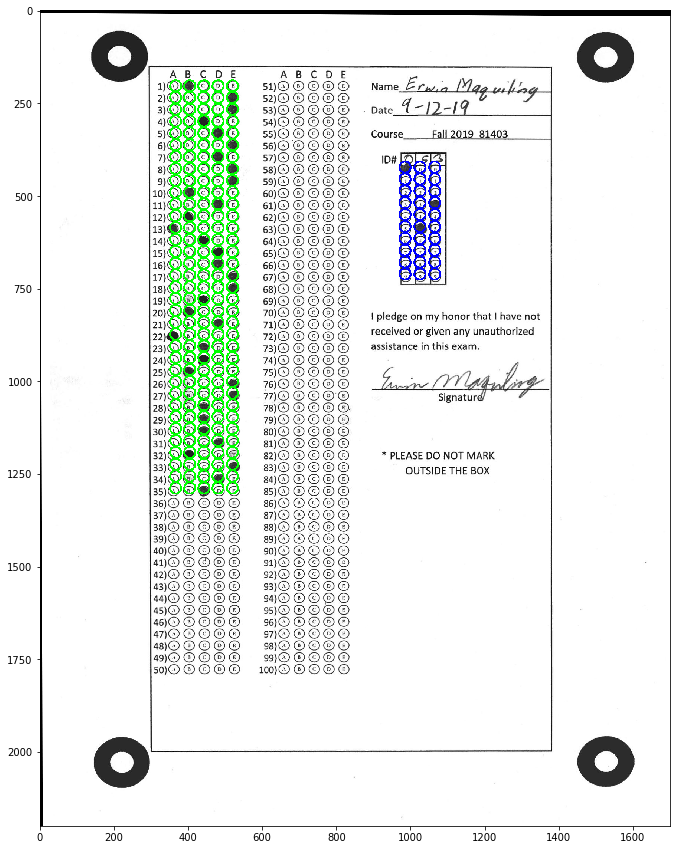

In [126]:
# building template
def build_align_img(img, alignment):
    print('build_align_img')
    points1 = get_corners(img)
    points2 = alignment
    print(points1)
    print(points2)
    
    if (points1 is None or len(points1) != 4):
        
        if points1 is not None:
            img_circled = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
            for i in range(len(points1)):
                c = points1[i]

                cv2.circle( img_circled, (c[0], c[1]), 60, (0, 255, 0), 4)
        #         print("i = %d, r = %f" % (i, c[2]))

            print("Circles Marked")
            plt.figure(figsize = (15,15))

            plt.imshow(img_circled, cmap='gray');

        else:
            print("circle is None")
        assert(False), "alignment failed!!"
        
    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Use homography
    if len(img.shape) == 3:
        height, width, _ = img.shape
    else:
        height, width = img.shape
    im1Reg = cv2.warpPerspective(img, h, (width, height))
#     plt.imshow(im1Reg);

    return im1Reg, h

def debug_align_img():
    srcimg = os.path.join(PATH, SRC_IMG)
    ti = cv2.imread('{}\Image001.jpg'.format(srcimg), 0)
    aimg, h = align_img(ti, build_alignment(ti))
    cti = cv2.cvtColor(ti, cv2.COLOR_GRAY2BGR)
    ret, mask = cv2.threshold(ti, 127, 255,cv2.THRESH_BINARY_INV)
    aimg = cv2.cvtColor(aimg, cv2.COLOR_GRAY2BGR)
    print(cti[mask == 255].shape, cti.shape, aimg.shape)
    cti[mask == 255] = [0,0,255]
    # cti[mask == 255] = (0,0,255)
    # for a in arr:
    #     cv2.circle(cti, (int(a[0]), int(a[1])), 60, (255,0,0), 5)
    weighted = cv2.addWeighted(cti, 0.6, aimg, 0.4, 0)
    plt.figure(figsize = (15,15))
    plt.imshow(weighted, cmap='gray');
# debug_align_img()

def build_roi(img, item):
    radius = 15
    if (item[2] == 0):
        top_left, bottom_right = (365, 204), (518, 1288) # manual input vs. autodetect
        entries, options, orientation = item
        xs = np.linspace(top_left[0],bottom_right[0],len(options)).astype(int)
        ys = np.linspace(top_left[1],bottom_right[1],entries).astype(int)
        circles = np.array([[x,y,radius] for y in ys for x in xs])
    else:
        top_left, bottom_right = (983, 423), (1063, 711) # manual input vs. autodetect
        entries, options, orientation = item
        xs = np.linspace(top_left[0],bottom_right[0],entries).astype(int)
        ys = np.linspace(top_left[1],bottom_right[1],len(options)).astype(int)
        circles = np.array([[x,y,radius] for x in xs for y in ys])
    print('building roi',circles.shape,circles[0],circles[-1])
    
    return circles

def debug_build_roi():
    srcimg = os.path.join(PATH, SRC_IMG)
    ti = cv2.imread('{}\Image001.jpg'.format(srcimg), 0)
    aimg, h = align_img(ti, build_alignment(ti))
    cv2.imwrite('alignedTemp.jpg',aimg)
    ai = cv2.cvtColor(aimg, cv2.COLOR_GRAY2BGR)
#     cs = build_roi(ti, ANSWERS[0])
    cs = build_roi(ti, IDS[0])
    for c in cs:
        cv2.circle(ai,(c[0],c[1]),c[2],(0,255,0),-1)
    plt.figure(figsize=(10,10))
    plt.imshow(ai, cmap='gray')
    ######################
    # Manually search tl, br corners:
    # cv2.circle(aimg, (365,204), 13, (0,255,0), -1)
    # cv2.circle(aimg, (518,1288), 13, (0,255,0), -1)
    # plt.figure(figsize=(8,8))
    # # plt.imshow(aimg, cmap='gray') 
    # # plt.imshow(aimg[190:220,350:380], cmap='gray')
    # plt.imshow(aimg[1250:1310,300:580], cmap='gray')
    return
# debug_build_roi()

def build_template(img, alignment, IDS, ANSWERS):
    '''
    align img and build ROIs for ID, Ans (list of circles to scan)
    '''
#     img = cv2.imread(file, 0)
    
    img, h = build_align_img(img, alignment)
    ans = [build_roi(img, ans) for ans in ANSWERS]
    ids = [build_roi(img, _) for _ in IDS]
    
    print('build_template succeed!')
    return ids, ans

def debug_build_template():
    firstImg = cv2.imread('{}\Image001.jpg'.format(srcimg), 0)
    alignment = build_alignment(firstImg)
    testImg = cv2.imread("{}\Image004.jpg".format(os.path.join(PATH, SRC_IMG)), 0)
    ids, ans = build_template(testImg, alignment, IDS, ANSWERS)
    print(np.array(ids).shape, np.array(ans).shape)
    img = testImg.copy()
    img, h = align_img(img, alignment)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    for i in ids[0]:
        cv2.circle(img, (i[0], i[1]), i[2], (0,0,255), 3)
    for i in ans[0]:
        cv2.circle(img, (i[0], i[1]), i[2], (0,255,0), 3)
    plt.figure(figsize=(15,15))
    plt.imshow(img, cmap='gray')
debug_build_template()

In [212]:
a = np.random.randint(10, size=(5,5))
b = np.random.randint(10, size=(5,5))
err = []
err.append('Image008.jpg')
print(err)
assert (len(err) >= 5) 
print(len(['Image008.jpg']))

['Image008.jpg']


AssertionError: 

44376.5
(962, 373, 127, 357)
[((4, 1, 2), 3736101.0), ((45, 1, 2), 44376.5), ((394, 1, 2), 10217.5), ((362, 1, 2), 10167.0), ((420, 1, 2), 10136.0)]


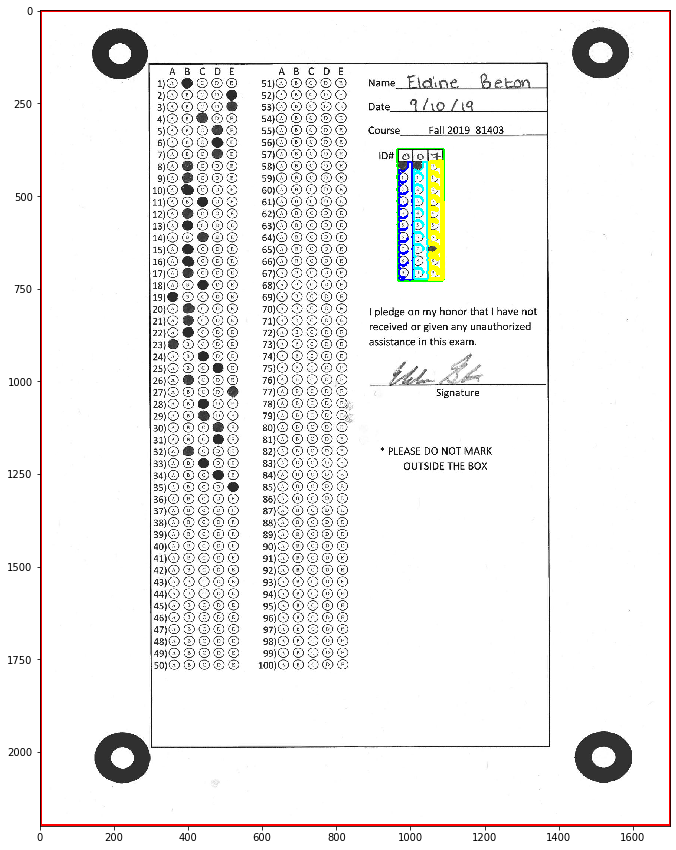

In [119]:
t_g = cv2.cvtColor(REFIM, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(t_g, (5, 5), 0)
_, b_w = cv2.threshold(blur, 127, 255, cv2.THRESH_BINARY)
edged = cv2.Canny(b_w, 75, 200)
b_w[:250, :] = 255
b_w[750:, :] = 255
b_w[:, :900], b_w[:, 1100:] = 255, 255
_, cnts, h = cv2.findContours(b_w, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
# print(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
print(cv2.contourArea(cnts[1]))
print(cv2.boundingRect(cnts[1]))

print([(i.shape, cv2.contourArea(i)) for i in cnts])

cimg = cv2.cvtColor(t_g, cv2.COLOR_GRAY2BGR)
cv2.drawContours(cimg, cnts, 0, (255,0,0), 10)
cv2.drawContours(cimg, cnts, 1, (0,255,0), 3)
cv2.drawContours(cimg, cnts, 2, (0,0,255), 3)
cv2.drawContours(cimg, cnts, 3, (255,255,0), 10)
cv2.drawContours(cimg, cnts, 4, (0,255,255), 3)

plt.figure(figsize = (15,15))

plt.imshow(cimg, cmap='gray');

0
Image001.jpg
processing image
Align image
0


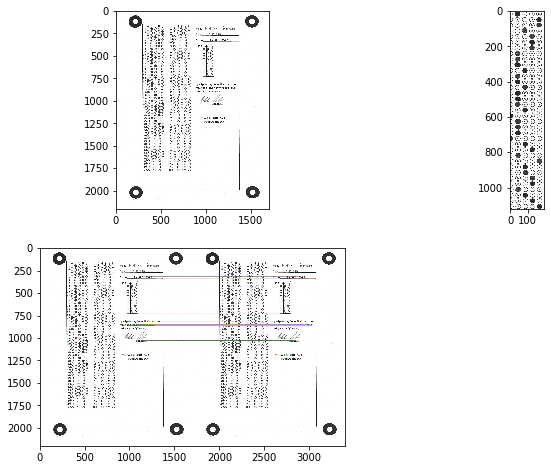

1
Image002.jpg
processing image
Align image
1021678


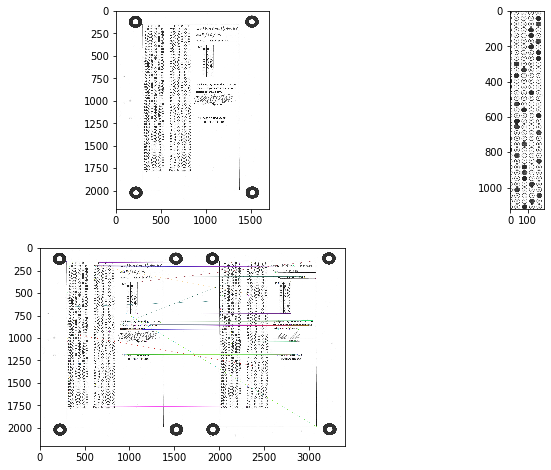

2
['Image001;A;B;C;D;E;F;G;0;0;4', 'Image002;A;B;C;D;E;F;G;0;0;4']


In [74]:
res = []
iii = 0
for filename in os.listdir(PATH):
    if iii > 1:
        break
    print (iii)
    iii += 1

    print(filename)
    # load image
    img = cv2.imread(".\img\{}".format(filename), 1)
    # process image
    ans, stid = process_image(img)
    entry = []
    entry.append(filename[:-4])
    entry.extend(ans)
    entry.extend(map(str,stid))
    res.append(";".join(entry))

print(iii)
print(res)

In [71]:
# def process_image(img):
    print("processing image")
    fig = plt.figure(figsize=(11,8))
    gs = gridspec.GridSpec(2,2,width_ratios=[5,1])
    fig.add_subplot(gs[0])
    plt.imshow(img)
    img_g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img_a, _, img_m = alignImages(img, REFIM)
    
    print(np.sum(img_g != cv2.cvtColor(img_a, cv2.COLOR_BGR2GRAY)))
    
    area1 = img_a[180:1300,355:550,:] # crop_ans_area(img, NUM_OF_QS)
    
    
    fig.add_subplot(gs[1])
    plt.imshow(area1)
    fig.add_subplot(gs[2])
    plt.imshow(img_m)
    plt.show()
    return [_ for _ in 'ABCDEFG'], [0,0,4]

In [73]:
def alignImages(im1, im2):
    print("Align image")
 
    # Convert images to grayscale
    im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(500)
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)

    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    numGoodMatches = int(len(matches) * 0.15)
    matches = matches[:numGoodMatches]

    # Draw top matches
    imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
#     cv2.imwrite("matches.jpg", imMatches)

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Use homography
    height, width, channels = im2.shape
    im1Reg = cv2.warpPerspective(im1, h, (width, height))

    return im1Reg, h, imMatches

i = cv2.imread('.\img\Image004.jpg')
j = cv2.imread('.\img\Image001.jpg')
test = alignImages(i,j)

Align image


check if circle is filled

In [ ]:
# check if circle is filled

circle_radius = tmp[...,-1].min()
kernel = np.ones((2*circle_radius,2*circle_radius),dtype=int)
out0 = convolve2d(255-img, kernel,'same')
detected_vals = out0[tmp[...,1], tmp[...,0]]
detected_vals -= detected_vals.min()
mask = detected_vals>detected_vals.max()/2

In [ ]:
# convert pdf2img
with tempfile.TemporaryDirectory() as path:
    images_from_path = convert_from_path('test.pdf', output_folder=path)
    cnt = 1
    for image in images_from_path:
        image.save("{}\Image{:03d}.jpg".format(PATH, cnt), "JPEG")
        cnt += 1

print("{} images have been generated from the PDF file".format(cnt-1))
